# Surface Type Classification by IMU Data Using End-to-End LSTM and Conv1D Networks

The aim of this notebook is to recognize the floor surface where a robot standing on using data collected from Inertial Measurement Units (IMU sensors).
IMU sensor data are collected while a small mobile robot driving over different floor surfaces. The task is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity.

## Data Description

X_[train].csv - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

    -row_id: The ID for this row.

    -series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

    -measurement_number: Measurement number within the series.

    The orientation channels encode the current angles how the robot is oriented as a quaternion (see Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:

    * orientation_X

    * orientation_Y

    * orientation_Z

    * orientation_W

    * angular_velocity_X

    * angular_velocity_Y

    * angular_velocity_Z

    * linear_acceleration_X

    * linear_acceleration_Y

    * linear_acceleration_Z

y_train.csv - the surfaces for training set.

    -series_id: ID number for the measurement series.

    -group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

    -surface: surface type.

Source:
https://www.kaggle.com/c/career-con-2019/overview

    
## Method

Recurrent neural networks are a class of neural networks for analysing time series and extracting time dependencies between instances of a signal. LSTM is a specialized RNN for handling long sequences. It can avoid vanishing gradients. 

The other method is 1D convolutional layers. It outperforms the LSTM in terms of final accuracy and training time. 




In [35]:
import tensorflow
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Dense, Softmax, RepeatVector, Flatten, ConvLSTM2D, MaxPooling1D, Conv1D, Concatenate, Input, GRU, GlobalAveragePooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import  plot_model


Loading the files and merging them to have signals and labels in a single dataframe. 


In [4]:
df_X_trn = pd.read_csv('X_train.csv')
df_y_trn = pd.read_csv('y_train.csv')

state_list = ['orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z']


floor_types = ['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood']

df_trn = pd.merge(df_X_trn,df_y_trn,on = 'series_id', how = 'inner')


Let's visualize the sensor data for different surface types. It is claear that the distributaions of the data are different for each surface. 


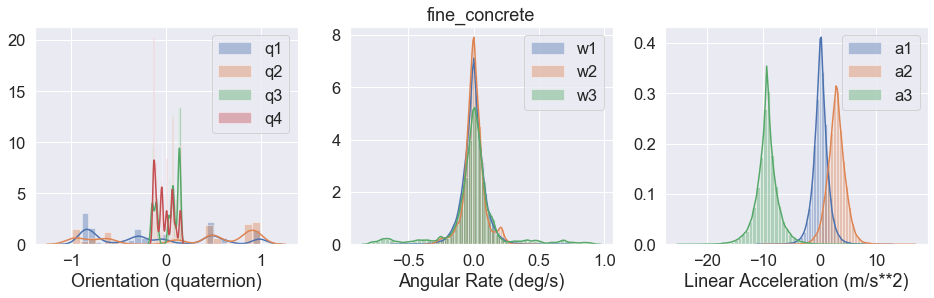

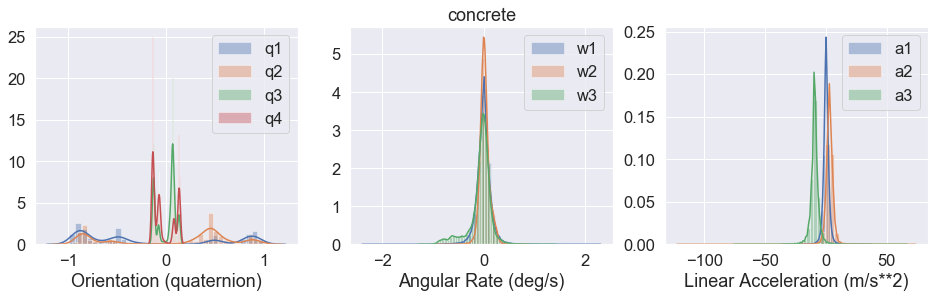

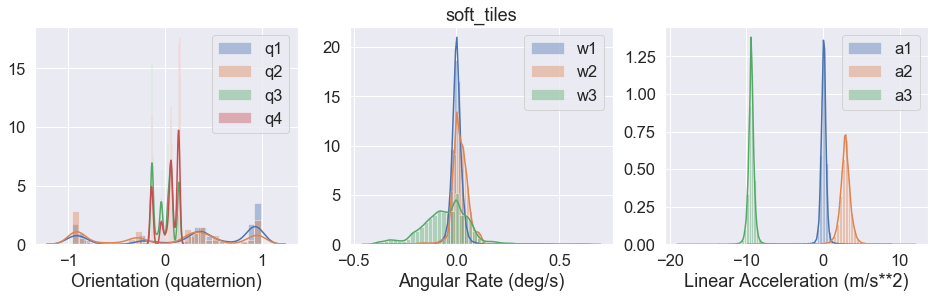

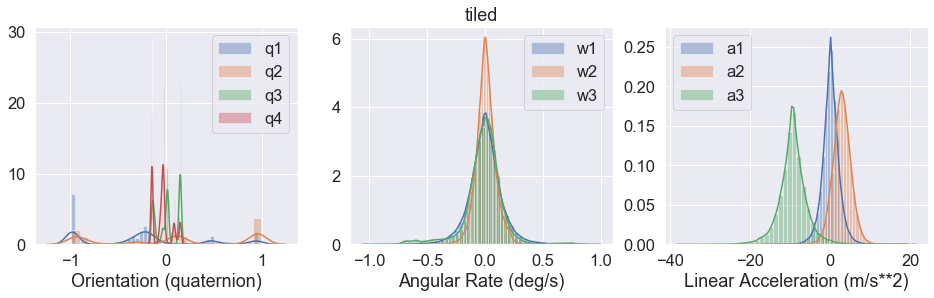

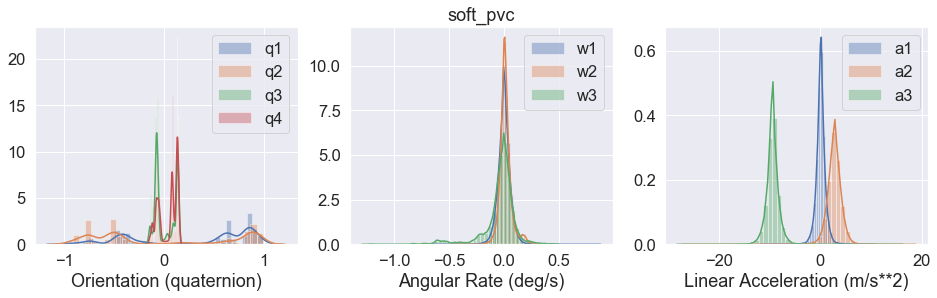

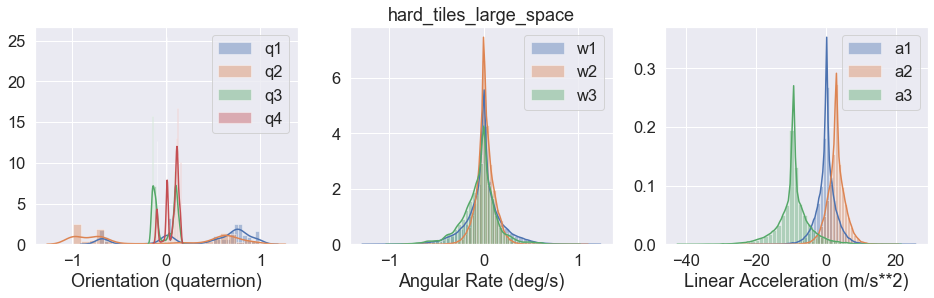

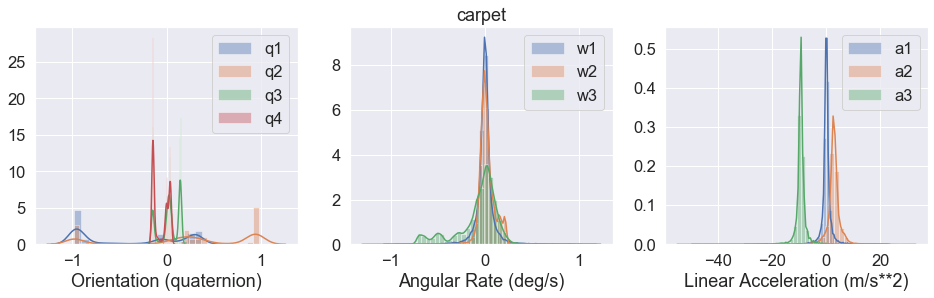

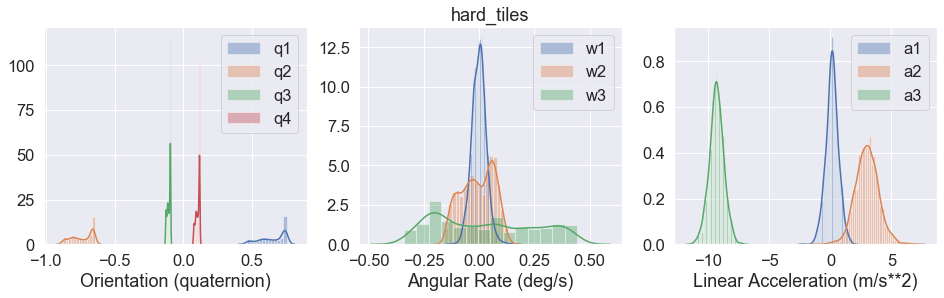

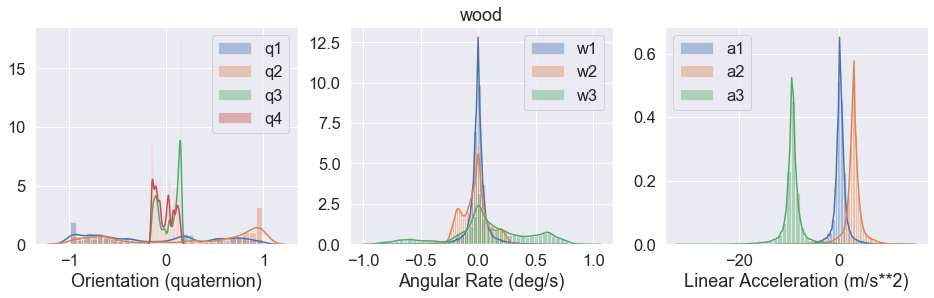

In [22]:
def plot_series_dist(surface):
    sns.set(color_codes=True, font_scale=1.5)
    
    fig,ax = plt.subplots(1,3, figsize = (16,4))
    sns.distplot(df_trn[df_trn['surface']==surface]['orientation_X'], label = 'q1', ax = ax[0])
    sns.distplot(df_trn[df_trn['surface']==surface]['orientation_Y'], label = 'q2', ax = ax[0])
    sns.distplot(df_trn[df_trn['surface']==surface]['orientation_Z'], label = 'q3', ax = ax[0])
    sns.distplot(df_trn[df_trn['surface']==surface]['orientation_W'], label = 'q4', ax = ax[0])
    ax[0].set_xlabel('Orientation (quaternion)')
    ax[0].legend()

    sns.distplot(df_trn[df_trn['surface']==surface]['angular_velocity_X'], label = 'w1', ax = ax[1])
    sns.distplot(df_trn[df_trn['surface']==surface]['angular_velocity_Y'], label = 'w2', ax = ax[1])
    sns.distplot(df_trn[df_trn['surface']==surface]['angular_velocity_Z'], label = 'w3', ax = ax[1])
    ax[1].set_xlabel('Angular Rate (deg/s)')
    ax[1].legend()
    ax[1].set_title(surface)


    sns.distplot(df_trn[df_trn['surface']==surface]['linear_acceleration_X'], label = 'a1', ax = ax[2])
    sns.distplot(df_trn[df_trn['surface']==surface]['linear_acceleration_Y'], label = 'a2', ax = ax[2])
    sns.distplot(df_trn[df_trn['surface']==surface]['linear_acceleration_Z'], label = 'a3', ax = ax[2])
    ax[2].legend()
    ax[2].set_xlabel('Linear Acceleration (m/s**2)')
    
        
for surf in floor_types:
    plot_series_dist(surf)


Next, the data are prepared for the model training. They are converted into timeseries with a length of 128 and 10 features. 


In [31]:
X_trn = df_trn.iloc[:,3:3+10].values
X_trn_std = X_trn - np.mean(X_trn, axis = 0)/np.std(X_trn, axis = 0)
X_trn_std = X_trn_std.reshape(3810,128,10)


In [32]:
y_features_trn = df_trn.groupby(['series_id','surface']).count().reset_index()['surface'].values
le = LabelEncoder()
y_features_trn = le.fit_transform(y_features_trn)
y_binary_trn = to_categorical(y_features_trn)
X_trn_std, X_val, y_binary_trn, y_binary_val = train_test_split(X_trn_std, y_binary_trn, test_size = 0.3)

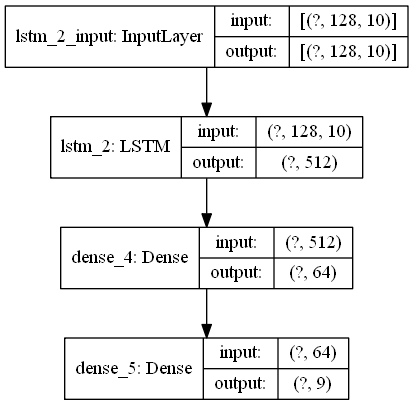

In [36]:
n_timesteps, n_features, n_outputs = X_trn_std.shape[1], X_trn_std.shape[2], y_binary_trn.shape[1]

model = Sequential()
model.add(LSTM(512, input_shape=(n_timesteps,n_features), return_sequences = False))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

plot_model(model, show_shapes=True, show_layer_names=True)

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_trn_std, y_binary_trn, epochs=100, batch_size=64, validation_data=(X_val, y_binary_val),verbose = 2)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

Epoch 64/100
42/42 - 28s - loss: 0.0546 - accuracy: 0.9865 - val_loss: 1.5134 - val_accuracy: 0.6973
Epoch 65/100
42/42 - 28s - loss: 0.1374 - accuracy: 0.9621 - val_loss: 1.6503 - val_accuracy: 0.6413
Epoch 66/100
42/42 - 28s - loss: 0.1862 - accuracy: 0.9303 - val_loss: 1.4499 - val_accuracy: 0.6763
Epoch 67/100
42/42 - 28s - loss: 0.1241 - accuracy: 0.9576 - val_loss: 1.4716 - val_accuracy: 0.6675
Epoch 68/100
42/42 - 28s - loss: 0.1745 - accuracy: 0.9430 - val_loss: 1.3909 - val_accuracy: 0.6780
Epoch 69/100
42/42 - 28s - loss: 0.1015 - accuracy: 0.9719 - val_loss: 1.3785 - val_accuracy: 0.6868
Epoch 70/100
42/42 - 28s - loss: 0.0430 - accuracy: 0.9906 - val_loss: 1.4192 - val_accuracy: 0.6947
Epoch 71/100
42/42 - 28s - loss: 0.0165 - accuracy: 0.9981 - val_loss: 1.4237 - val_accuracy: 0.7017
Epoch 72/100
42/42 - 31s - loss: 0.0123 - accuracy: 0.9974 - val_loss: 1.4182 - val_accuracy: 0.7078
Epoch 73/100
42/42 - 28s - loss: 0.0161 - accuracy: 0.9951 - val_loss: 1.4123 - val_accurac

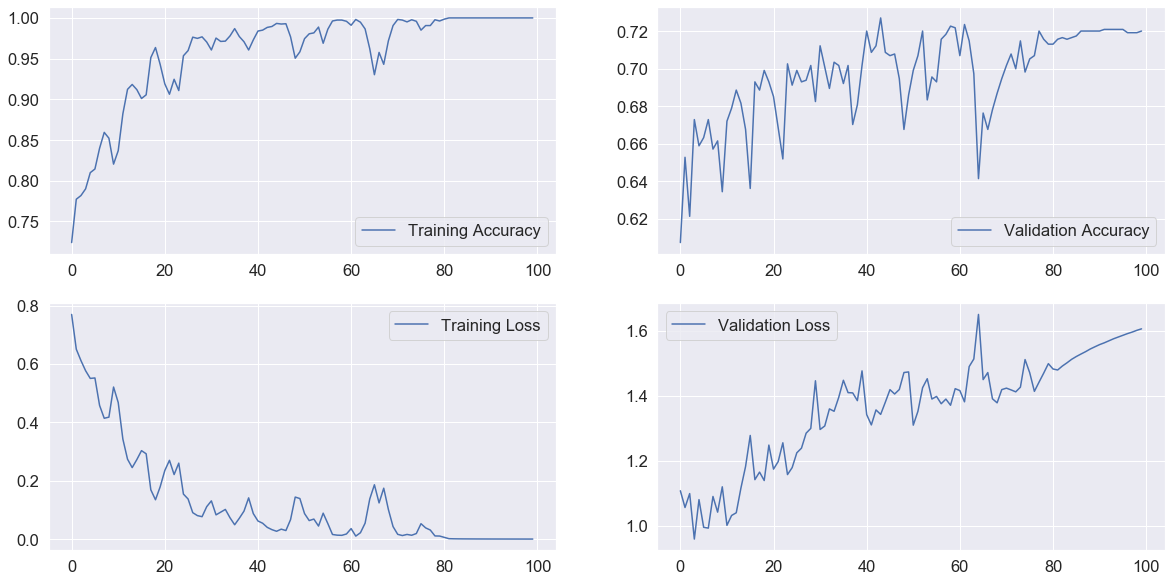

In [42]:
fig,ax = plt.subplots(2,2, figsize = (20,10))
ax[0,0].plot(history.history['accuracy'],label = 'Training Accuracy')
ax[0,0].legend()
ax[0,1].plot(history.history['val_accuracy'],label = 'Validation Accuracy')
ax[0,1].legend()
ax[1,0].plot(history.history['loss'],label = 'Training Loss')
ax[1,0].legend()
ax[1,1].plot(history.history['val_loss'],label = 'Validation Loss')
ax[1,1].legend()

## Early fusion conv1D network:

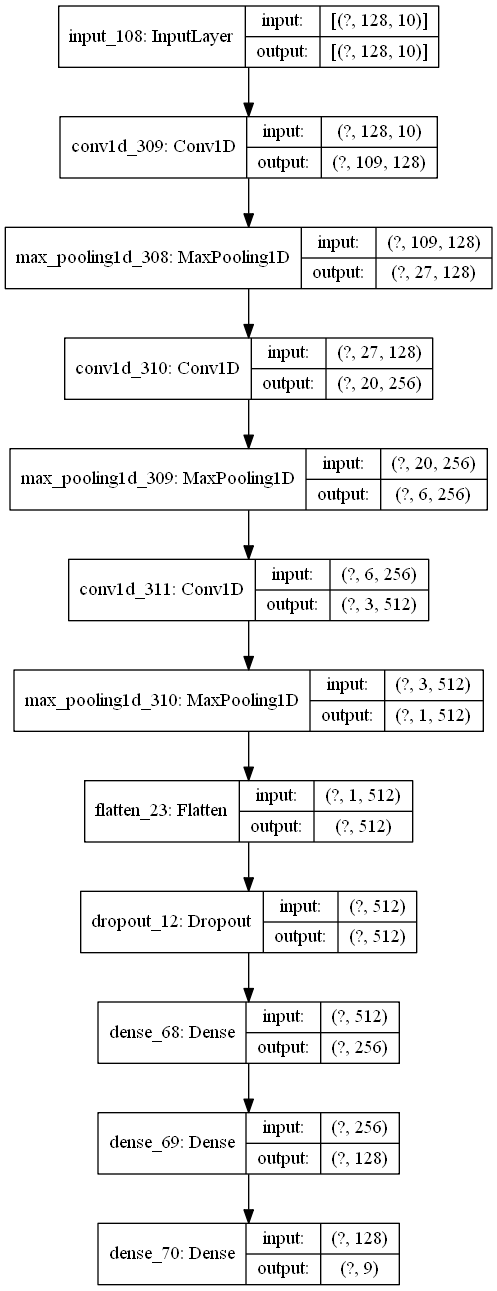

In [115]:
inputA = Input(shape=(128,10))

branch_1 = (Conv1D(128, 20, activation='relu'))(inputA)
branch_1 = (MaxPooling1D(4))(branch_1)
branch_1 = (Conv1D(256, 8, activation='relu'))(branch_1)
branch_1 = (MaxPooling1D(3))(branch_1)
branch_1 = (Conv1D(512, 4, activation='relu'))(branch_1)
branch_1 = (MaxPooling1D(3))(branch_1)

merged = Flatten()(branch_1)
merged = Dropout(0.4)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dense(128, activation='relu')(merged)

out = Dense(n_outputs, activation='softmax')(merged)
model = Model(inputs = inputA, outputs = out)
plot_model(model, show_shapes=True, show_layer_names=True)

In [116]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_trn_std, y_binary_trn, epochs=100, batch_size=64, validation_data=(X_val, y_binary_val),verbose = 2)

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

Epoch 65/100
42/42 - 2s - loss: 0.1641 - accuracy: 0.9471 - val_loss: 1.5208 - val_accuracy: 0.7253
Epoch 66/100
42/42 - 2s - loss: 0.1704 - accuracy: 0.9501 - val_loss: 1.4764 - val_accuracy: 0.7288
Epoch 67/100
42/42 - 2s - loss: 0.1681 - accuracy: 0.9509 - val_loss: 1.0336 - val_accuracy: 0.7839
Epoch 68/100
42/42 - 2s - loss: 0.0553 - accuracy: 0.9835 - val_loss: 1.1337 - val_accuracy: 0.7752
Epoch 69/100
42/42 - 2s - loss: 0.0645 - accuracy: 0.9794 - val_loss: 1.2947 - val_accuracy: 0.7690
Epoch 70/100
42/42 - 2s - loss: 0.0724 - accuracy: 0.9775 - val_loss: 1.4788 - val_accuracy: 0.7638
Epoch 71/100
42/42 - 2s - loss: 0.0703 - accuracy: 0.9711 - val_loss: 1.5710 - val_accuracy: 0.7524
Epoch 72/100
42/42 - 2s - loss: 0.1115 - accuracy: 0.9651 - val_loss: 1.3973 - val_accuracy: 0.7585
Epoch 73/100
42/42 - 2s - loss: 0.0704 - accuracy: 0.9738 - val_loss: 1.4100 - val_accuracy: 0.7717
Epoch 74/100
42/42 - 2s - loss: 0.1202 - accuracy: 0.9584 - val_loss: 1.4978 - val_accuracy: 0.7594


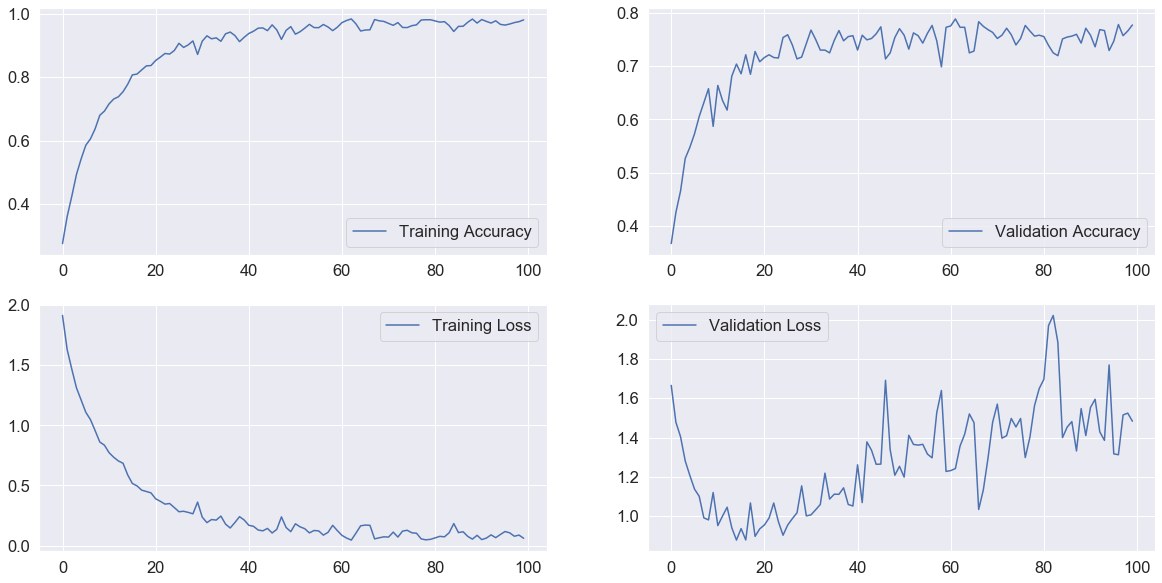

In [117]:
fig,ax = plt.subplots(2,2, figsize = (20,10))
ax[0,0].plot(history.history['accuracy'],label = 'Training Accuracy')
ax[0,0].legend()
ax[0,1].plot(history.history['val_accuracy'],label = 'Validation Accuracy')
ax[0,1].legend()
ax[1,0].plot(history.history['loss'],label = 'Training Loss')
ax[1,0].legend()
ax[1,1].plot(history.history['val_loss'],label = 'Validation Loss')
ax[1,1].legend()

## Late fusion conv1D network:


In [43]:
X_dataset_q = X_trn_std[:,:,:4]
X_dataset_w = X_trn_std[:,:,4:7]
X_dataset_a = X_trn_std[:,:,7:]


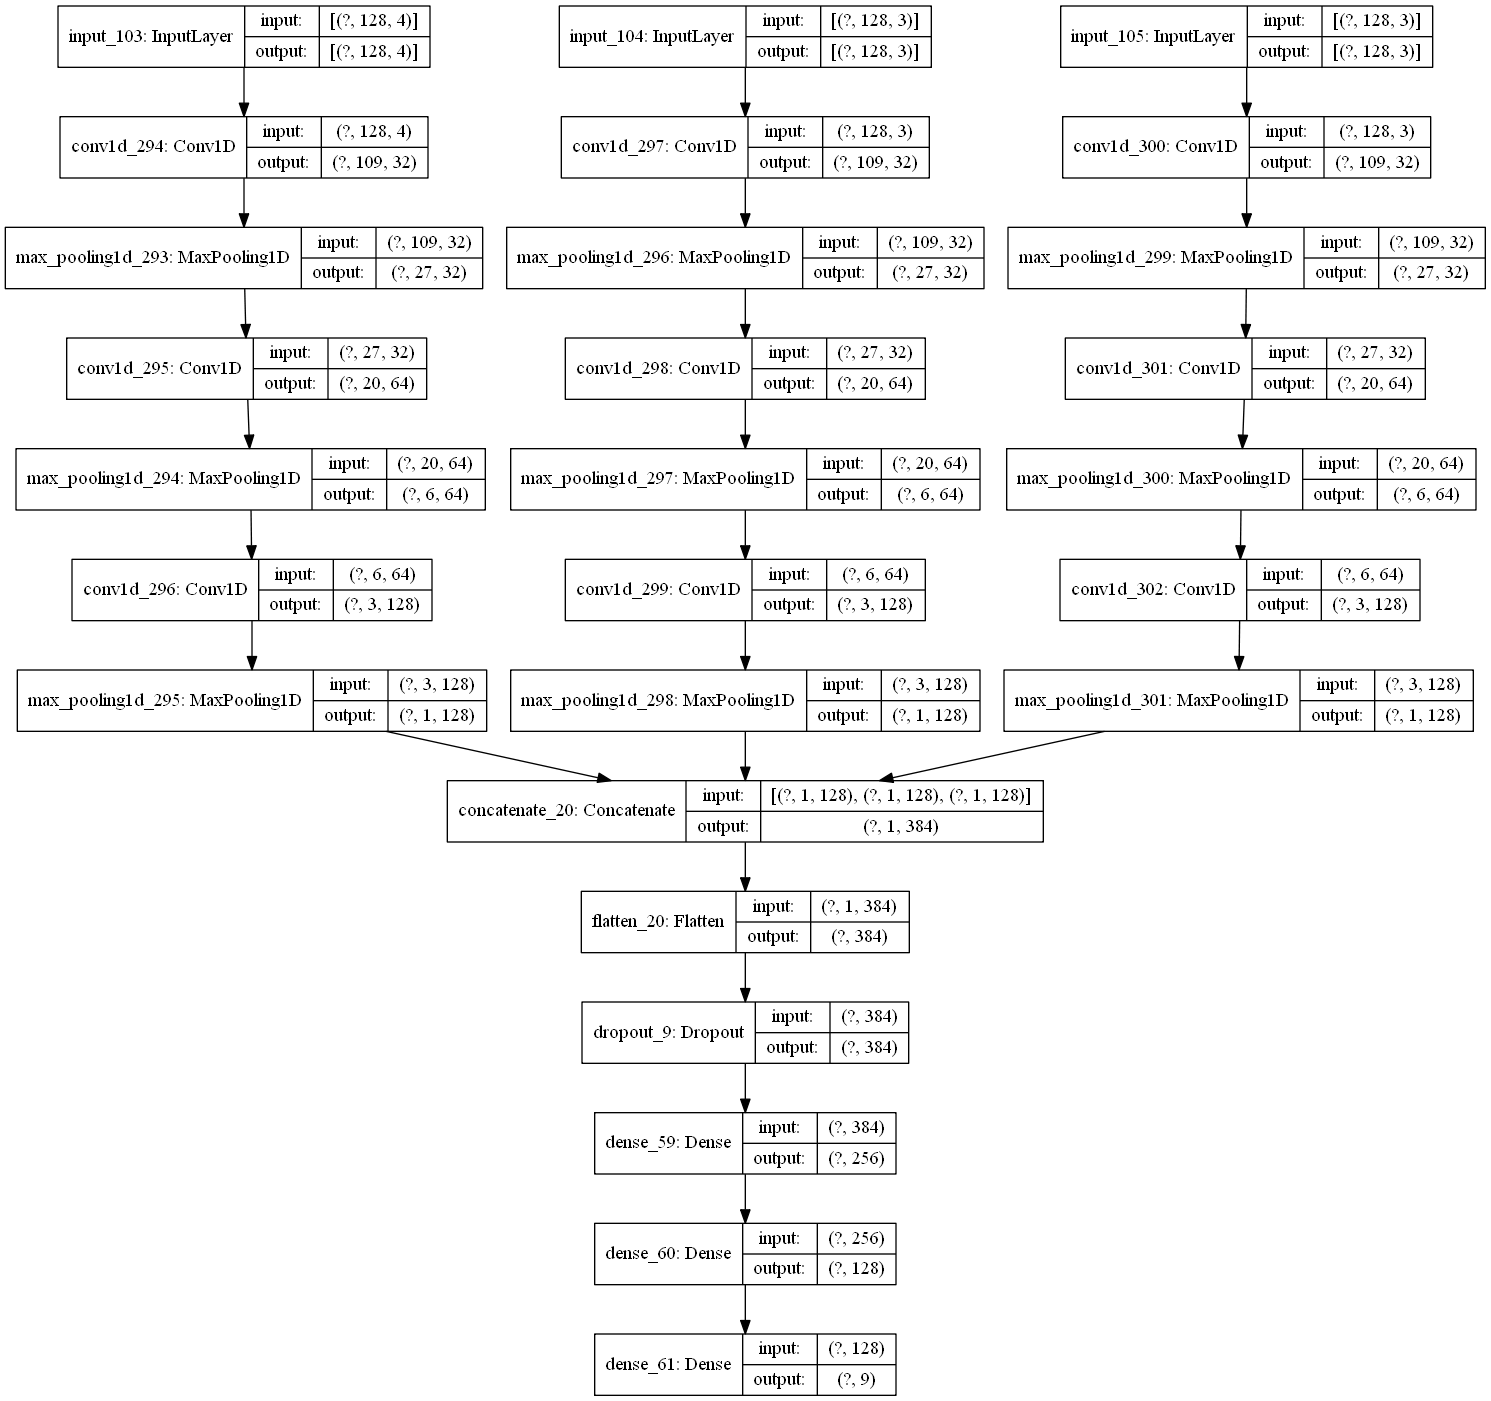

In [108]:
inputA = Input(shape=(128,4))
inputB = Input(shape=(128,3))
inputC = Input(shape=(128,3))

branch_1 = (Conv1D(32, 20, activation='relu'))(inputA)
branch_1 = (MaxPooling1D(4))(branch_1)
branch_1 = (Conv1D(64, 8, activation='relu'))(branch_1)
branch_1 = (MaxPooling1D(3))(branch_1)
branch_1 = (Conv1D(128, 4, activation='relu'))(branch_1)
branch_1 = (MaxPooling1D(3))(branch_1)

branch_2 = (Conv1D(32, 20, activation='relu'))(inputB)
branch_2 = (MaxPooling1D(4))(branch_2)
branch_2 = (Conv1D(64, 8, activation='relu'))(branch_2)
branch_2 = (MaxPooling1D(3))(branch_2)
branch_2 = (Conv1D(128, 4, activation='relu'))(branch_2)
branch_2 = (MaxPooling1D(3))(branch_2)

branch_3 = (Conv1D(32, 20, activation='relu'))(inputC)
branch_3 = (MaxPooling1D(4))(branch_3)
branch_3 = (Conv1D(64, 8, activation='relu'))(branch_3)
branch_3 = (MaxPooling1D(3))(branch_3)
branch_3 = (Conv1D(128, 4, activation='relu'))(branch_3)
branch_3 = (MaxPooling1D(3))(branch_3)

merged = tensorflow.keras.layers.concatenate([branch_1,branch_2,branch_3],axis = -1)
merged = Flatten()(merged)
merged = Dropout(0.4)(merged)
merged = Dense(256, activation='relu')(merged)
merged = Dense(128, activation='relu')(merged)

out = Dense(n_outputs, activation='softmax')(merged)
model = Model(inputs=[inputA, inputB, inputC], outputs = out)
plot_model(model, show_shapes=True, show_layer_names=True)

In [111]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([X_trn_std[:,:,:4], X_trn_std[:,:,4:7], X_trn_std[:,:,7:]], y_binary_trn, epochs=250, batch_size = 64, validation_data=([X_val[:,:,:4], X_val[:,:,4:7], X_val[:,:,7:]],y_binary_val), verbose = 2)

Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing 

Epoch 65/250
42/42 - 0s - loss: 0.0528 - accuracy: 0.9809 - val_loss: 0.9486 - val_accuracy: 0.8259
Epoch 66/250
42/42 - 0s - loss: 0.0702 - accuracy: 0.9768 - val_loss: 0.9283 - val_accuracy: 0.8163
Epoch 67/250
42/42 - 0s - loss: 0.0718 - accuracy: 0.9771 - val_loss: 0.8804 - val_accuracy: 0.8329
Epoch 68/250
42/42 - 0s - loss: 0.0479 - accuracy: 0.9824 - val_loss: 0.8900 - val_accuracy: 0.8259
Epoch 69/250
42/42 - 0s - loss: 0.0440 - accuracy: 0.9865 - val_loss: 0.9524 - val_accuracy: 0.8276
Epoch 70/250
42/42 - 1s - loss: 0.0345 - accuracy: 0.9884 - val_loss: 0.9564 - val_accuracy: 0.8373
Epoch 71/250
42/42 - 0s - loss: 0.0352 - accuracy: 0.9858 - val_loss: 1.0858 - val_accuracy: 0.8276
Epoch 72/250
42/42 - 1s - loss: 0.0307 - accuracy: 0.9906 - val_loss: 0.9650 - val_accuracy: 0.8399
Epoch 73/250
42/42 - 1s - loss: 0.0441 - accuracy: 0.9858 - val_loss: 1.1418 - val_accuracy: 0.8206
Epoch 74/250
42/42 - 1s - loss: 0.0349 - accuracy: 0.9865 - val_loss: 0.9908 - val_accuracy: 0.8154


Epoch 147/250
42/42 - 1s - loss: 0.0656 - accuracy: 0.9760 - val_loss: 1.0376 - val_accuracy: 0.8259
Epoch 148/250
42/42 - 1s - loss: 0.0248 - accuracy: 0.9929 - val_loss: 1.0484 - val_accuracy: 0.8136
Epoch 149/250
42/42 - 1s - loss: 0.0645 - accuracy: 0.9801 - val_loss: 1.2100 - val_accuracy: 0.8093
Epoch 150/250
42/42 - 1s - loss: 0.0743 - accuracy: 0.9753 - val_loss: 1.1029 - val_accuracy: 0.8180
Epoch 151/250
42/42 - 1s - loss: 0.0814 - accuracy: 0.9753 - val_loss: 1.0895 - val_accuracy: 0.8189
Epoch 152/250
42/42 - 1s - loss: 0.0611 - accuracy: 0.9794 - val_loss: 1.2258 - val_accuracy: 0.8075
Epoch 153/250
42/42 - 1s - loss: 0.0338 - accuracy: 0.9888 - val_loss: 1.0343 - val_accuracy: 0.8294
Epoch 154/250
42/42 - 1s - loss: 0.0329 - accuracy: 0.9888 - val_loss: 1.2143 - val_accuracy: 0.8206
Epoch 155/250
42/42 - 1s - loss: 0.0292 - accuracy: 0.9899 - val_loss: 1.0200 - val_accuracy: 0.8241
Epoch 156/250
42/42 - 1s - loss: 0.0408 - accuracy: 0.9876 - val_loss: 1.1204 - val_accurac

42/42 - 0s - loss: 0.0161 - accuracy: 0.9936 - val_loss: 1.1337 - val_accuracy: 0.8303
Epoch 229/250
42/42 - 0s - loss: 0.0132 - accuracy: 0.9948 - val_loss: 1.1205 - val_accuracy: 0.8355
Epoch 230/250
42/42 - 0s - loss: 0.0311 - accuracy: 0.9899 - val_loss: 1.1324 - val_accuracy: 0.8276
Epoch 231/250
42/42 - 0s - loss: 0.0269 - accuracy: 0.9910 - val_loss: 1.2284 - val_accuracy: 0.8233
Epoch 232/250
42/42 - 0s - loss: 0.0394 - accuracy: 0.9903 - val_loss: 1.2764 - val_accuracy: 0.8136
Epoch 233/250
42/42 - 0s - loss: 0.0481 - accuracy: 0.9861 - val_loss: 1.1414 - val_accuracy: 0.8320
Epoch 234/250
42/42 - 1s - loss: 0.0701 - accuracy: 0.9805 - val_loss: 1.2340 - val_accuracy: 0.8198
Epoch 235/250
42/42 - 0s - loss: 0.0281 - accuracy: 0.9906 - val_loss: 1.0563 - val_accuracy: 0.8390
Epoch 236/250
42/42 - 0s - loss: 0.0255 - accuracy: 0.9921 - val_loss: 1.0960 - val_accuracy: 0.8381
Epoch 237/250
42/42 - 0s - loss: 0.0234 - accuracy: 0.9921 - val_loss: 1.1260 - val_accuracy: 0.8329
Epoc

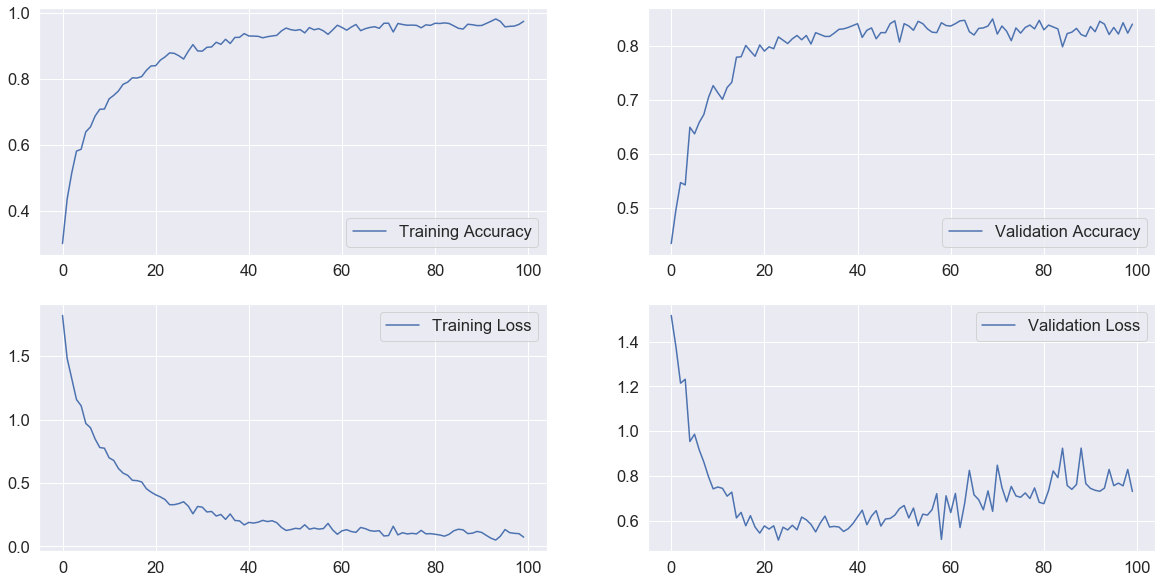

In [110]:
fig,ax = plt.subplots(2,2, figsize = (20,10))
ax[0,0].plot(history.history['accuracy'],label = 'Training Accuracy')
ax[0,0].legend()
ax[0,1].plot(history.history['val_accuracy'],label = 'Validation Accuracy')
ax[0,1].legend()
ax[1,0].plot(history.history['loss'],label = 'Training Loss')
ax[1,0].legend()
ax[1,1].plot(history.history['val_loss'],label = 'Validation Loss')
ax[1,1].legend()